# <h1><font color="red">Usando Pytorch Lightning para treinar um modelo de classificação para CIFAR100</font></h1>

<font color="pink">Senior Data Scientist.: Eddy Giusepe Chirinos Isidro</font>


# <font color="gree">Carregando e visualizando os dados `CIFAR100`</font>

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import pytorch_lightning as pl

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np


2025-01-11 15:59:45.849270: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 15:59:45.856933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736621985.866548   34121 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736621985.869440   34121 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 15:59:45.879413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Definindo as transformações para treino (com data augmentation):
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(15),  # Rotação aleatória até 15 graus
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Ajustes de cor
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


# Transformando os dados em tensores e normalizando. Transformações para validação e teste (sem data augmentation):
transform = transforms.Compose([transforms.ToTensor(), # Carregadas como arrays NumPy ou objetos PIL.
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] # Normaliza os valores das imagens de [0, 255] (valores típicos de pixels) para [0, 1]
                              )


# Carregando o conjunto de treino completo:
full_train_dataset = torchvision.datasets.CIFAR100(root='./data',
                                                   train=True,
                                                   download=True
                                                  )

# Dividindo o conjunto de treino em treino e validação (80% treino, 20% validação)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset_raw, val_dataset_raw = random_split(full_train_dataset, [train_size, val_size])


Files already downloaded and verified


In [3]:
# Aplicando as transformações apropriadas para cada conjunto:
train_dataset = torch.utils.data.dataset.Subset(torchvision.datasets.CIFAR100(root='./data',
                                                                              train=True,
                                                                              transform=transform_train),
                                                                              train_dataset_raw.indices
                                                )

val_dataset = torch.utils.data.dataset.Subset(torchvision.datasets.CIFAR100(root='./data',
                                                                            train=True,
                                                                            transform=transform),
                                                                            val_dataset_raw.indices
                                                                            )

# Carregando o conjunto de teste:
test_dataset = torchvision.datasets.CIFAR100(root='./data',
                                              train=False,
                                              download=True,
                                              transform=transform
                                             )


Files already downloaded and verified


In [4]:
# Função para extrair informações do dataset:
def visualizar_dataset_info(dataset, num_amostras=5):
    dados = []
    for i in range(num_amostras):
        imagem, label = dataset[i]
        # Verifica se é um objeto Subset (treino/validação) ou CIFAR100 (teste)
        if hasattr(dataset, 'dataset'):
            classes = dataset.dataset.classes
        else:
            classes = dataset.classes
            
        dados.append({
            'índice': i,
            'classe': classes[label],
            'label': label,
            'formato_imagem': imagem.shape
        })
    return pd.DataFrame(dados)

In [5]:
# Visualizando informações do dataset de treino:
train_info_df = visualizar_dataset_info(train_dataset)
train_info_df

,índice,classe,label,formato_imagem
0,0,mouse,50,"(3, 32, 32)"
1,1,forest,33,"(3, 32, 32)"
2,2,apple,0,"(3, 32, 32)"
3,3,spider,79,"(3, 32, 32)"
4,4,skyscraper,76,"(3, 32, 32)"


In [6]:
# Visualizando informações do dataset de validação:
val_info_df = visualizar_dataset_info(val_dataset)
val_info_df

,índice,classe,label,formato_imagem
0,0,whale,95,"(3, 32, 32)"
1,1,beaver,4,"(3, 32, 32)"
2,2,pickup_truck,58,"(3, 32, 32)"
3,3,plate,61,"(3, 32, 32)"
4,4,beaver,4,"(3, 32, 32)"


In [7]:
# Agora podemos visualizar qualquer dataset
test_info_df = visualizar_dataset_info(test_dataset)
test_info_df

,índice,classe,label,formato_imagem
0,0,mountain,49,"(3, 32, 32)"
1,1,forest,33,"(3, 32, 32)"
2,2,seal,72,"(3, 32, 32)"
3,3,mushroom,51,"(3, 32, 32)"
4,4,sea,71,"(3, 32, 32)"


In [8]:
train_dataset

In [9]:
val_dataset

In [10]:
test_dataset

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [11]:
# Criando os dataloader (gerenciar o carregamento de dados):
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=10
                                          )

val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=64,
                                           shuffle=False, # Datasets de validação e teste devem ser determinísticos. O embaralhamento pode dificultar a reprodutibilidade dos resultados
                                           num_workers=10
                                          )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=64,
                                           shuffle=False, # Datasets de validação e teste devem ser determinísticos. O embaralhamento pode dificultar a reprodutibilidade dos resultados
                                           num_workers=10
                                          )



In [12]:
# Criando uma função para visualização de imagens:
def imshow(img):
    plt.figure(figsize=(12, 12))
    img = img / 2 + 0.5 # Desnormalização
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.axis('off')
    plt.title("Image examples of the CIFAR100 dataset", fontsize=20, color='red')
    plt.show()


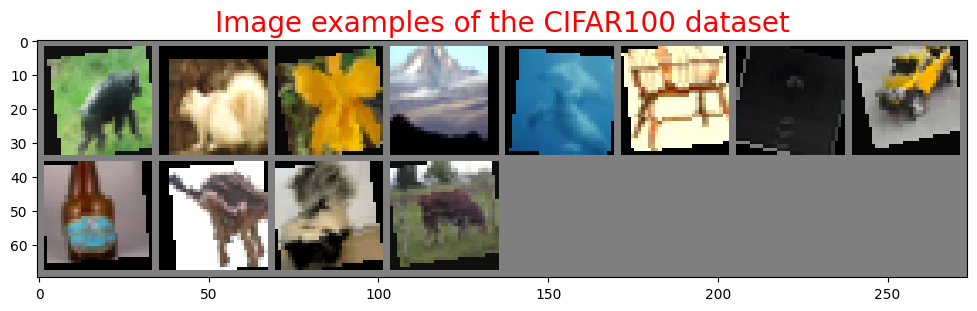

In [13]:
# Selecionando algumas imagens aleatórias para visualização do conjunto de treinamento:
dataiter = iter(train_loader)

images, labels = next(dataiter)

# Mostrando as imagens:
imshow(torchvision.utils.make_grid(images[:12]))



In [14]:
# Imprimindo informações detalhadas sobre os dados:
print(f'Número de imagens de treino: {len(train_dataset)}')
print(f'Número de imagens de teste: {len(test_dataset)}')
print('\nInformações sobre o formato das imagens:')
print(f'Formato: {images[0].shape} -> (Canais, Altura, Largura)')
print(f'- Canais: {images[0].shape[0]} (RGB - Red, Green, Blue)')
print(f'- Altura: {images[0].shape[1]} pixels')
print(f'- Largura: {images[0].shape[2]} pixels')
print(f'- Total de valores por imagem (3x32x32): {images[0].shape[0] * images[0].shape[1] * images[0].shape[2]} pixels')
print(f'\nNúmero de classes: {len(full_train_dataset.classes)}')

Número de imagens de treino: 40000
Número de imagens de teste: 10000

Informações sobre o formato das imagens:
Formato: torch.Size([3, 32, 32]) -> (Canais, Altura, Largura)
- Canais: 3 (RGB - Red, Green, Blue)
- Altura: 32 pixels
- Largura: 32 pixels
- Total de valores por imagem (3x32x32): 3072 pixels

Número de classes: 100


# <font color="gree">Usando Lightning para definir o Modelo</font>

Se você não quer construir o modelo e quer usar um modelo pré-treinado como `ResNet`, você pode usar o `Lightning` para definir o modelo.
Isso será abordado em outro notebook.

In [15]:
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CIFAR100Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Primeiro bloco convolucional:
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Segundo bloco convolucional:
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Terceiro bloco convolucional:
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Quarto bloco convolucional:
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 100)  # CIFAR100 tem 100 classes
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        # Adicionando prog_bar=True e on_step=True para mostrar na barra de progresso:
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        # Adicionando os mesmos parâmetros de logging:
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_step=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        # Adicionando os mesmos parâmetros de logging:
        self.log("test_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("test_acc", acc, prog_bar=True, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                               lr=1e-3,
                               weight_decay=1e-2
                              )
        
        # scheduler = optim.lr_scheduler.ReduceLROnPlateau( # Melhor para fine-tuning ou quando não se sabe quantas epochs serão necessárias
        # optimizer,
        # mode='max', # Monitora quando queremos maximizar a métrica (accuracy)
        # factor=0.2, # Fator de redução da taxa de aprendizado (LR)
        # patience=3, # Espera 3 épocas sem melhoria para reduzir a taxa de aprendizado
        # verbose=True # Mostra mensagens quando a taxa de aprendizado é alterada
        #                                                 )
        # return {
        #     "optimizer": optimizer,
        #     "lr_scheduler": scheduler,
        #     "monitor": "val_acc"
        # }
    
        # Calculando o total de passos de treinamento
        steps_per_epoch = len(train_loader)  # Usando o train_loader diretamente
        total_steps = steps_per_epoch * self.trainer.max_epochs
        
        scheduler = optim.lr_scheduler.OneCycleLR( # Melhor para treinamento do zero (from scratch)
            optimizer,
            max_lr=1e-3,
            total_steps=total_steps,
            pct_start=0.3,  # 30% do treinamento para a fase de aquecimento
            div_factor=25,  # lr_inicial = max_lr/25
            final_div_factor=1000  # lr_final = lr_inicial/1000
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"  # OneCycleLR atualiza a cada batch
            }
        }

# <font color="gree">Treinamento com o Trainer</font>

In [16]:
%cd /home/eddygiusepe/2_EddyGiusepe_Estudo/LightningAI/2_Pytorch_Lightning_CIFAR100

/home/eddygiusepe/2_EddyGiusepe_Estudo/LightningAI/2_Pytorch_Lightning_CIFAR100


In [17]:
from pytorch_lightning import Trainer
#from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Logger opcional para salvar os resultados:
#logger = CSVLogger(save_dir="logs/", name="cifar100_experiment")

# Criar o logger do TensorBoard para acompanhar o treinamento:
logger = TensorBoardLogger(save_dir="logs/", name="cifar100_experiment")

# Inicialize o modelo:
model = CIFAR100Classifier()

# Salvar o melhor modelo com base na acurácia de validação:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    filename="best_model-{epoch:02d}-{val_acc:.2f}",
    save_top_k=1
)

# Inicialize o Trainer:
trainer = Trainer(
    max_epochs=15,
    accelerator="gpu",  # Use GPU se disponível
    devices=1,          # Número de GPUs
    callbacks=[checkpoint_callback],
    logger=logger,
    log_every_n_steps=10,
)

# Treinamento:
trainer.fit(model, train_loader, val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 2000 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 17.4 M | train
---------------------------------------------
17.4 M    Trainable params
0         Non-trainable params
17.4 M    Total params
69.519    Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


## <font color="blue">Acompanhando o treinamento com TensorBoard</font>

* `No terminal:`

```bash
tensorboard --logdir /home/eddygiusepe/2_EddyGiusepe_Estudo/LightningAI/2_Pytorch_Lightning/logs/cifar100_experiment
```


* `Numa célula do Jupyter Notebook:`

```bash
%load_ext tensorboard
%tensorboard --logdir /home/eddygiusepe/2_EddyGiusepe_Estudo/LightningAI/2_Pytorch_Lightning/logs/cifar100_experiment
```


# <font color="gree"> Avaliando o Modelo</font>

In [18]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.5103999972343445     │
│      test_loss_epoch      │    1.7439812421798706     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 1.7439812421798706, 'test_acc_epoch': 0.5103999972343445}]